 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 01. Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
import torch

GPUID = 0
DEVICE = torch.device('cuda:' + str(GPUID))
print('Execution device: ', DEVICE)
print('PyTorch version: ', torch.__version__)
print('CUDA available: ', torch.cuda.is_available())
print('CUDA version: ', torch.version.cuda)
print('CUDA device:', torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [2]:
from ptyrad.initialization import Initializer
from ptyrad.models import PtychoAD
from ptyrad.optimization import CombinedLoss, CombinedConstraint, ptycho_recon, loss_logger
from ptyrad.visualization import plot_forward_pass, plot_scan_positions, plot_summary, plot_pos_grouping, plot_probe_modes
from ptyrad.utils import test_loss_fn, select_scan_indices, make_batches, make_recon_params_dict, make_output_folder, save_results, get_blob_size, imshift_batch

Importing ptyrad 0.1.0-alpha2.7


# 02. Initialize optimization

In [3]:
from ptyrad.inputs.params_multi_obj import exp_params, source_params
# from ptyrad.inputs.params_CNS import exp_params, source_params
# from ptyrad.inputs.params_PSO_128 import exp_params, source_params
# from ptyrad.inputs.params_tBL_WSe2 import exp_params, source_params

# from ptyrad.inputs.params_BaM_128 import exp_params, source_params
# from ptyrad.inputs.params_BaM_256 import exp_params, source_params
# from ptyrad.inputs.params_STO_128 import exp_params, source_params
# from ptyrad.inputs.params_NNO3 import exp_params, source_params
# from ptyrad.inputs.params_Si_128 import exp_params, source_params
# from ptyrad.inputs.params_PdPt import exp_params, source_params



In [4]:
init = Initializer(exp_params, source_params).init_all()


### Initializing cache ###
use_cached_obj   = False
use_cached_probe = False
use_cached_pos   = False

### Initializing exp_params ###
Input values are displayed below:
kv: 80
conv_angle: 20
Npix: 180
rbf: None
dx_spec: 0.12
defocus: -200
c3: 0
z_distance: 10
Nlayer: 1
N_scans: 9494
N_scan_slow: 101
N_scan_fast: 94
scan_step_size: 0.3
scan_flip: None
scan_affine: None
omode_max: 4
pmode_max: 2
pmode_init_pows: [0.02]
probe_permute: None
cbeds_permute: None
cbeds_reshape: None
cbeds_flipT: None
probe_simu_params: None
Derived values given input exp_params:
kv          = 80 kV
wavelength  = 0.0418 Ang
conv_angle  = 20 mrad
Npix        = 180 px
dk          = 0.0463 Ang^-1
kMax        = 4.1667 Ang^-1
alpha_max   = 173.9882 mrad
dx          = 0.1200 Ang, Nyquist-limited dmin = 2*dx = 0.2400 Ang
Rayleigh-limited resolution  = 1.2736 Ang (0.61*lambda/alpha for focused probe )
Real space probe extent = 21.6000 Ang

### Initializing measurements from 'hdf5' ###
Success! .hdf5 file path = data/

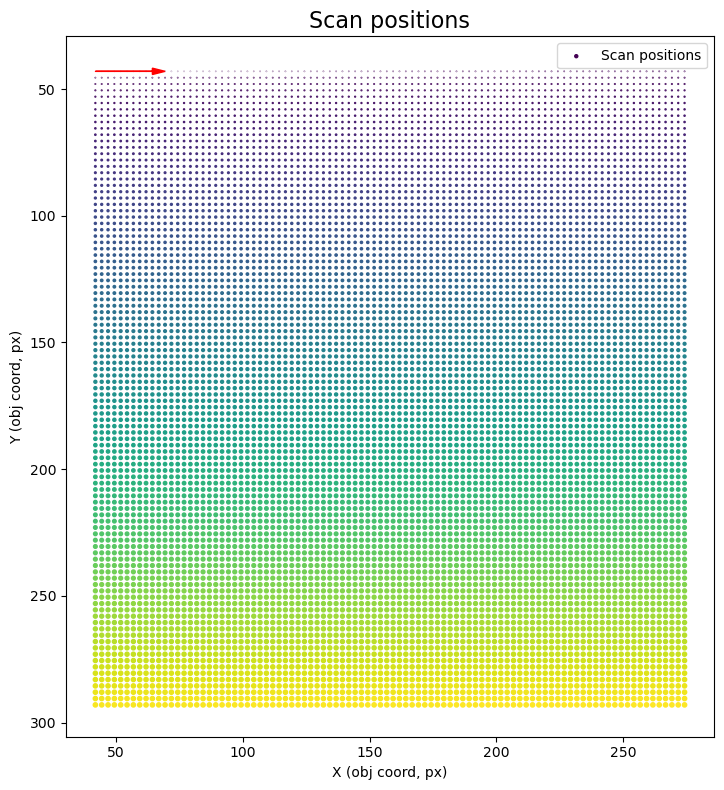

In [5]:
pos = init.init_variables['crop_pos'] + init.init_variables['probe_pos_shifts']
plot_scan_positions(pos)

In [6]:
model_params = {
    'detector_blur_std': 0,
    'lr_params':{
        'obja': 0,
        'objp': 5e-4,
        'probe': 5e-4, 
        'probe_pos_shifts': 5e-4}}

model = PtychoAD(init.init_variables, model_params, device=DEVICE)

# Use model.set_optimizer(new_lr_params) to update the variable flag and optimizer_params
optimizer = torch.optim.Adam(model.optimizer_params)

PtychoAD optimizable variables:
obja            : torch.Size([4, 1, 516, 495])    , torch.float32   , device:cuda:0, grad:False, lr:0e+00
objp            : torch.Size([4, 1, 516, 495])    , torch.float32   , device:cuda:0, grad:True , lr:5e-04
probe           : torch.Size([2, 180, 180])       , torch.complex64 , device:cuda:0, grad:True , lr:5e-04
probe_pos_shifts: torch.Size([9494, 2])           , torch.float32   , device:cuda:0, grad:True , lr:5e-04

Make sure to pass the optimizer_params to optimizer using "optimizer = torch.optim.Adam(model.optimizer_params)"

Total measurement values:    307,605,600                
Total optimizing variables:  1,105,468                
Overdetermined ratio:        278.26


## Check the forward pass

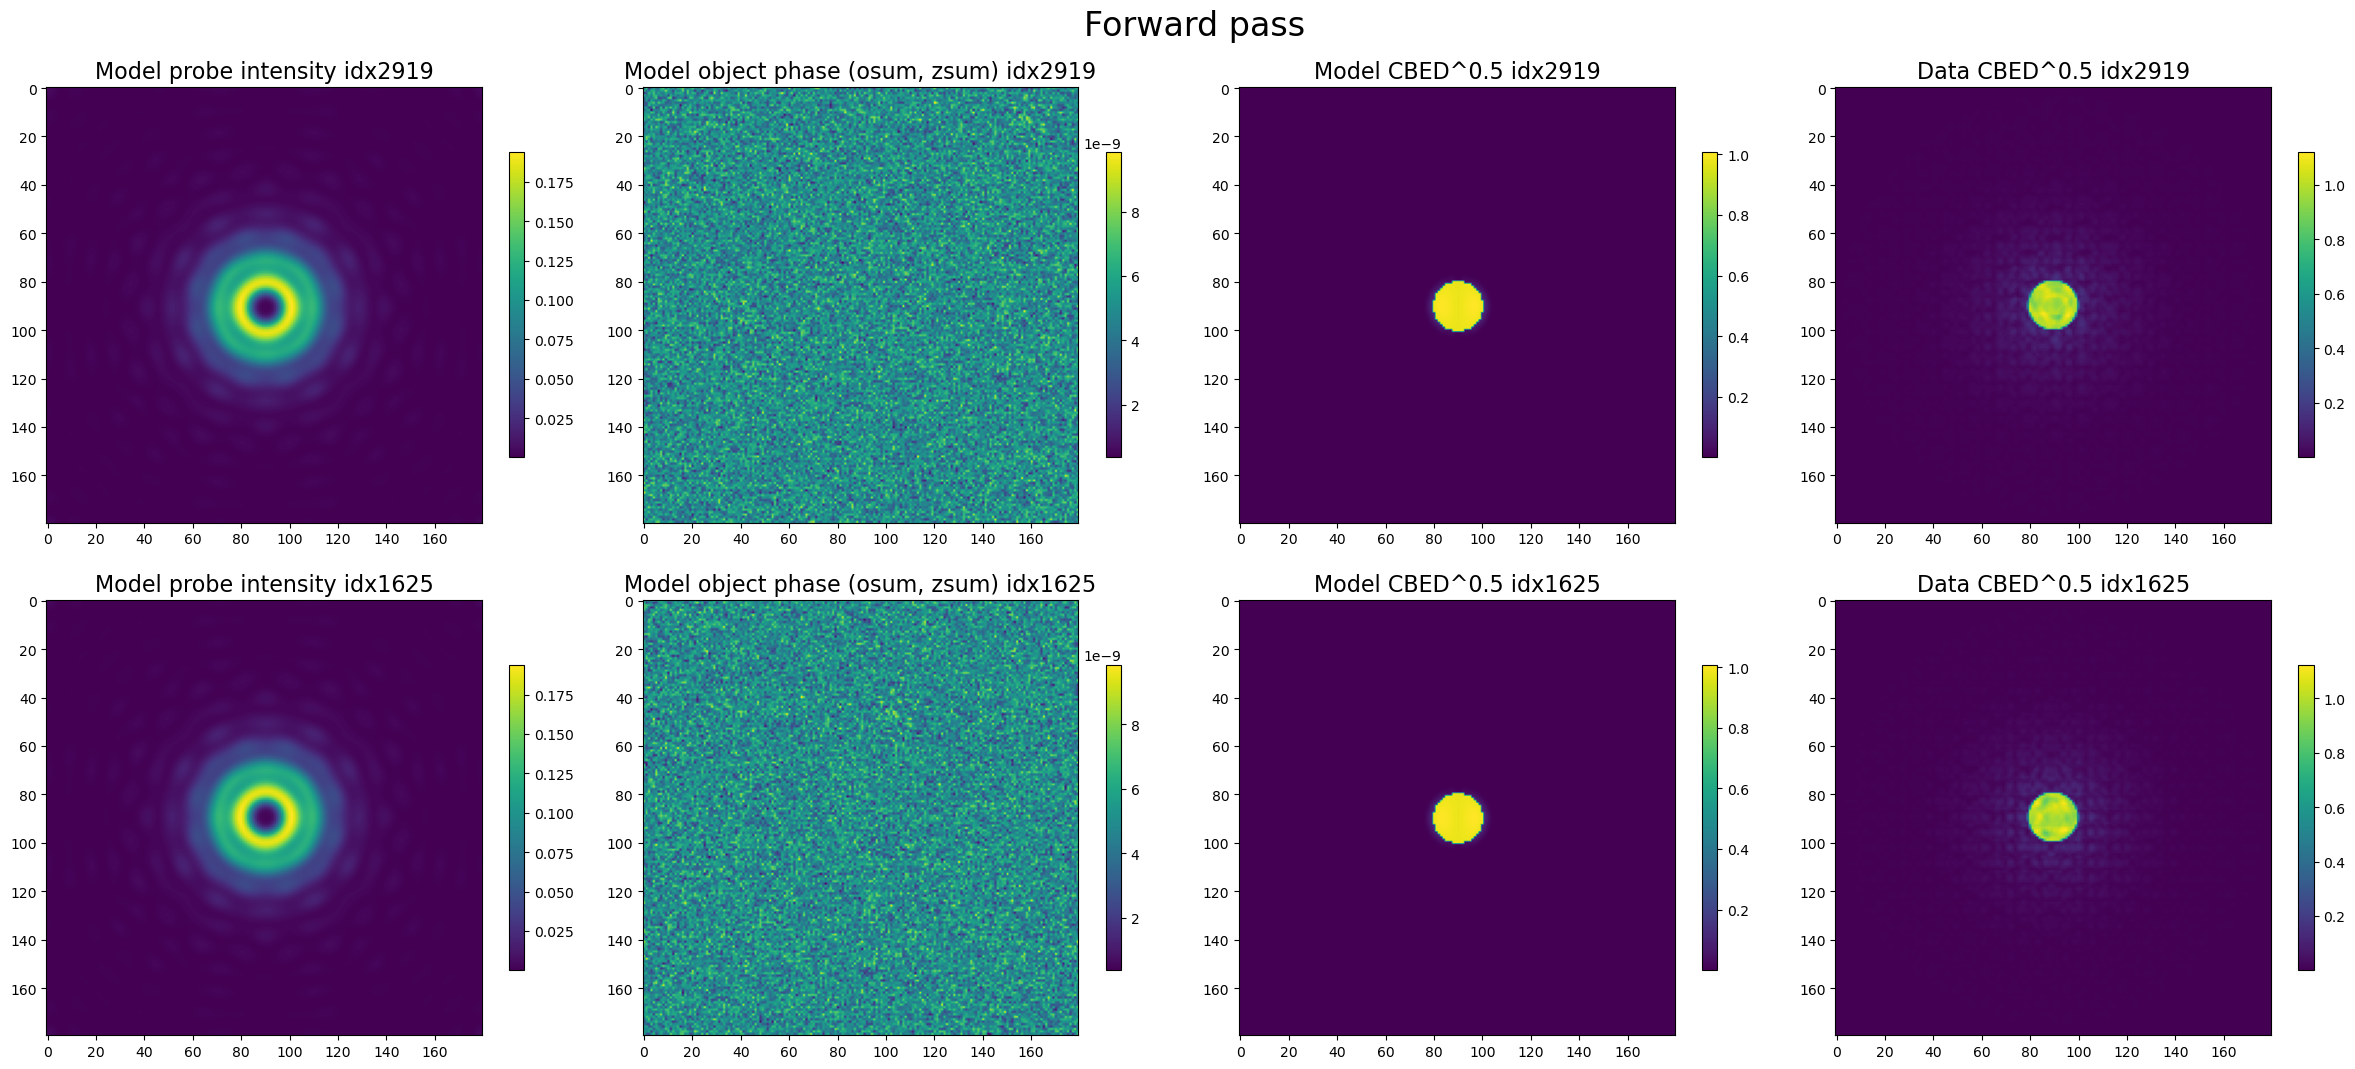

In [7]:
indices = np.random.randint(0,exp_params['N_scans'],2)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power)

## Finetune the loss params

In [8]:
loss_params = {
    'loss_single': {'state':  True,  'weight': 1.0, 'dp_pow': 0.5},
    'loss_pacbed': {'state': False,  'weight': 1.0, 'dp_pow': 0.2},
    'loss_tv'    : {'state': False,  'weight': 2e-4},
    'loss_l1'    : {'state': False,  'weight': 0.1},
    'loss_l2'    : {'state': False,  'weight': 1.0},
    'loss_postiv': {'state': False,  'weight': 1.0}
}

indices = np.random.randint(0,exp_params['N_scans'], 16)
loss_fn = CombinedLoss(loss_params, device=DEVICE)
test_loss_fn(model, indices, loss_fn)

loss_single: 1.58373475
loss_pacbed: 0.00000000
loss_tv    : 0.00000000
loss_l1    : 0.00000000
loss_l2    : 0.00000000
loss_postiv: 0.00000000


# Setup the iteration-wise constraint params

In [9]:
constraint_params = {
    'objp_blur'     : {'freq': None, 'std':None},
    'ortho_pmode'   : {'freq': 1},
    'ortho_omode'   : {'freq': None}, # This feature is still under construction, don't use it yet
    'kz_filter'     : {'freq': None, 'beta':1, 'alpha':1, 'z_pad':None, 'obj_type':'both'},
    'postiv'        : {'freq': 1},
    'fix_probe_int' : {'freq': 1}
}

constraint_fn = CombinedConstraint(constraint_params, device=DEVICE)

# 03. Main optimization loop

Selecting indices with the 'full' mode 
Generated 148 'sparse' groups of ~64 scan positions in 17.610 sec
output_path = 'output/multi_obj/full_N9494_dp180_sparse64_p2_plr5e-4_olr5e-4_slr5e-4_4obj_1slice_no_omode_occu_update' is generated!


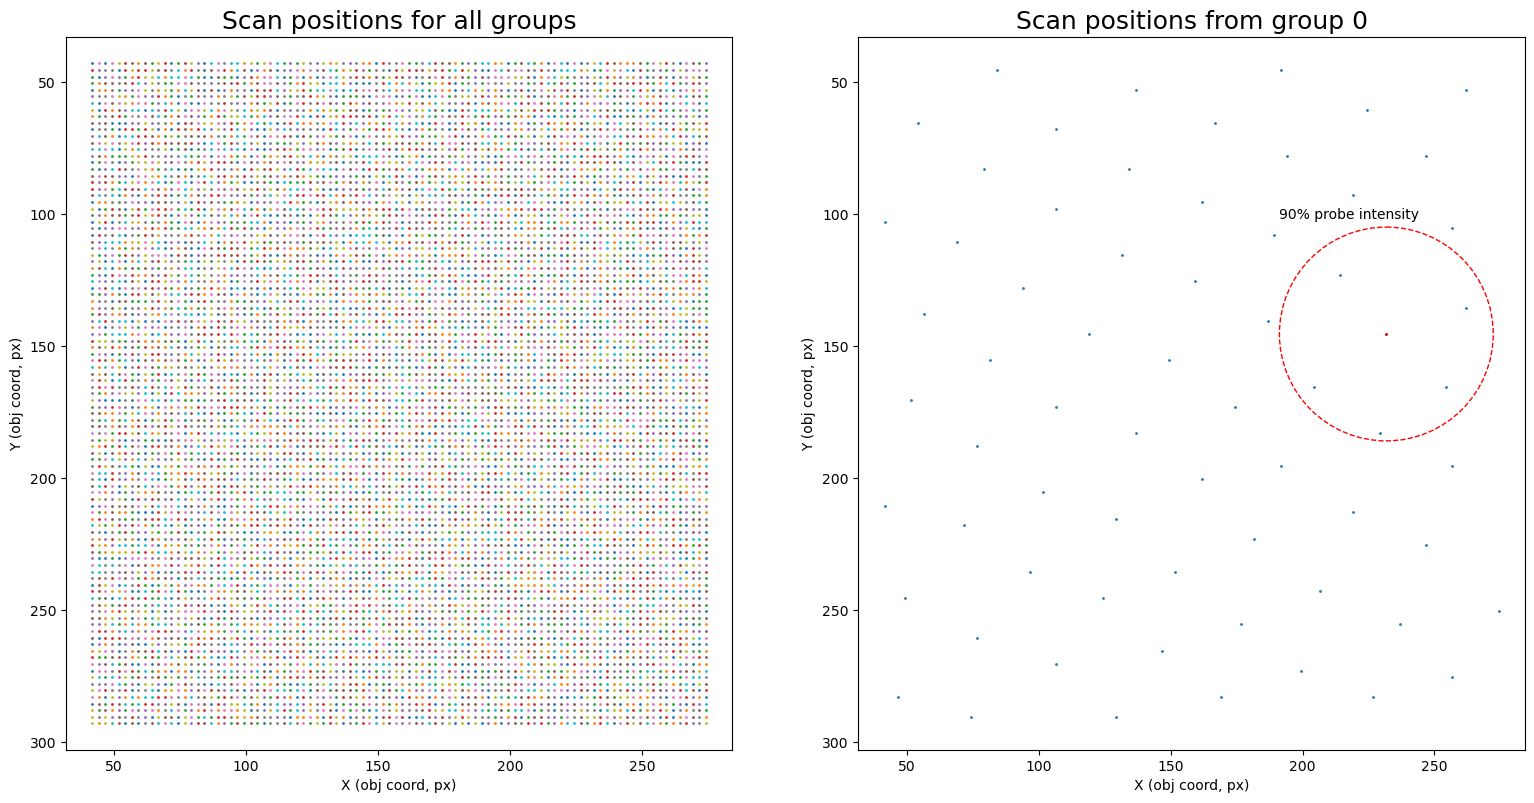

In [10]:
NITER        = 100
INDICES_MODE = 'full'   # 'full', 'center', 'sub'
BATCH_SIZE   = 64
GROUP_MODE   = 'sparse' # 'random', 'sparse', 'compact'
SAVE_ITERS   = 10        # scalar or None

output_dir   = 'output/multi_obj'
postfix      = ''

pos          = (model.crop_pos + model.opt_probe_pos_shifts).detach().cpu().numpy()
probe_int    = model.opt_probe[0].abs().pow(2).detach().cpu().numpy()
dx           = exp_params['dx_spec']
d90          = get_blob_size(dx, probe_int)
indices      = select_scan_indices(exp_params['N_scan_slow'], exp_params['N_scan_fast'], subscan_slow=None, subscan_fast=None, mode=INDICES_MODE)
batches      = make_batches(indices, pos, BATCH_SIZE, mode=GROUP_MODE)
recon_params = make_recon_params_dict(NITER, INDICES_MODE, BATCH_SIZE, GROUP_MODE, SAVE_ITERS)
output_path  = make_output_folder(output_dir, indices, exp_params, recon_params, model, constraint_params, postfix)

fig_grouping = plot_pos_grouping(pos, batches, circle_diameter=d90/dx, dot_scale=1, pass_fig=True)
fig_grouping.savefig(output_path + f"/summary_pos_grouping.png")

In [11]:
loss_iters = []
for niter in range(1, NITER+1):
    
    shuffle(batches)
    batch_losses, iter_t = ptycho_recon(batches, model, optimizer, loss_fn, constraint_fn, niter)
    loss_iters.append((niter, loss_logger(batch_losses, niter, iter_t)))
    
    ## Saving intermediate results
    if SAVE_ITERS is not None and niter % SAVE_ITERS == 0:
        save_results(output_path, model, exp_params, source_params, loss_params, constraint_params, recon_params, loss_iters, iter_t, niter, batch_losses)
        
        ## Saving summary
        plot_summary(output_path, loss_iters, niter, indices, init.init_variables, model, show_fig=False, save_fig=True)

Done batch 1 in 0.462 sec
Done batch 30 in 0.078 sec
Done batch 59 in 0.078 sec
Done batch 89 in 0.064 sec
Done batch 118 in 0.066 sec
Done batch 148 in 0.078 sec
Apply ortho pmode constraint at iter 1, relative pmode power = [0.942 0.058]
Apply ortho omode constraint at iter 1, relative omode power = [1. 0. 0. 0.]
Apply hard positivity objp constraint at iter 1
Apply fix probe int constraint at iter 1, probe int sum = 334.4174
Iter: 1, Total Loss: 0.5048, loss_single: 0.5048, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, loss_postiv: 0.0000, in 0.0 min 11.659660 sec
Done batch 1 in 0.075 sec
Done batch 30 in 0.074 sec
Done batch 59 in 0.078 sec
Done batch 89 in 0.076 sec
Done batch 118 in 0.066 sec
Done batch 148 in 0.077 sec
Apply ortho pmode constraint at iter 2, relative pmode power = [0.945 0.055]
Apply ortho omode constraint at iter 2, relative omode power = [0.71 0.29 0.   0.  ]
Apply hard positivity objp constraint at iter 2
Apply fix probe int constra

KeyboardInterrupt: 